# Introduction to Transformers in Julia
This notebook presents an introduction to Transformers in Julia. The following code contains a toy model example demonstrating a **very** simple transformer and also one slightly more optimised and improved for better performance. I also present a simple training script which uses an autoregressive training scheme to learn a model to predict how to generate the next amino acid in an antibody sequence. I then also demonstrate how you can perform sampling by a simple greedy sampling loop which iteratively adds token to an antibody sequence. Note that to run the antibody training code you will need to download some sequences from [here](https://opig.stats.ox.ac.uk/webapps/oas/oas_unpaired/) or you can try training on something else!

I hope that if you're interested in learning how to work with transformers this notebook can serve as a good initial introduction. If you do however want to deepen your understanding I recommend some of the following resources:
- 3Blue1Brown's Transformer [video series](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
- Andrej Karpathy's [youtube videos](https://www.youtube.com/@AndrejKarpathy)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- If you want the deepest understanding I also recommend reading some of the hallmark paper's which have layed the groundwork for transformers, like *Attention is All You Need*
- Also, looking through the [Onion.jl](https://github.com/MurrellGroup/Onion.jl/tree/main) or [Transformers.jl](https://github.com/chengchingwen/Transformers.jl) can be a good way to spend some time
- You can also always email me at: jack.collier.ryder@gmail.com

 ## Our First Toy Model 

In [ ]:
# For this model we use the Attention and RoPE functions from the Onion.jl package
# Flux will be used later for the training and the dense layers in the model also come from there
using Flux
using Onion
using Onion: Attention, causal_mask

# This transformer layer is the layer which contains the feedforward and attention parts of the code: the model's processing part
# We create a struct which consists of the attention layer (from Onion.jl) and a feedforward network which we say is just a chain of 2 dense layers
struct TransformerLayer
    attention::Attention
    ff::Chain
end

# This line is important to make all of the parameters trainable!
Flux.@layer TransformerLayer

# Constructor function for our transformer layers
function TransformerLayer(dim::Int, n_head::Int)
    return TransformerLayer(
        Attention(dim, n_head),
        Chain(Dense(dim, 4dim, relu), Dense(4dim, dim))
    )
end

# The actual forward pass of our transformer layer
function (layer::TransformerLayer)(x::AbstractArray)
    # These first four lines are used to create an attention mask and to prepare our positional encoding
    # Our attention mask is a causal mask which is a mask which makes it so that each token in the sequence can only attend to the tokens before itself
    # This is important if we don't want data leakage since we're training a model to predict the next token!
    seqlen = size(x, 2)
    h = zeros(Float32, layer.attention.dim, seqlen, 1)
    mask = causal_mask(h)
    # The RoPE is the positional encoding that I've decided to use. This is a more modern type of positional encdoing (it's from like 2021, but remember that the og transformer is from 2017..)
    # which uses a rotation matrix to encode the position of the tokens in the sequence. Without this the model won't ever know what position a token is at in a sequence, and this can obviously become problematic!
    # Consider language just!
    rope = RoPE(layer.attention.head_dim, seqlen)

    # These two layers then perform the attention and then return the input after having passed it through that feedforward network!
    x = layer.attention(x, 1, rope, mask)
    return layer.ff(x)
end

# This is our struct for our transformer model core
# Here we also specify what layers we want in the model; for this toy example we have
# - The input embedding (here called vocab_embed)
# - A vector of TransformerLayers
# - An output projection
struct ToyModel
    vocab_embed::Dense
    layers::Vector{TransformerLayer}
    proj::Dense
end

# To make our parameters trainable!
Flux.@layer ToyModel

# Constructor function for our model
function ToyModel(layers::Int, dim::Int, n_head::Int)
    vocab_embed = Dense(vocab_size, dim, bias=false)
    layers = [TransformerLayer(dim, n_head) for _ in 1:layers]
    proj = Dense(dim, vocab_size)
    return ToyModel(vocab_embed, layers, proj)
end

# Here is our forward pass for the model
function (model::ToyModel)(x)
    # First we embed our sequences into that high-dim vector space 
    x = model.vocab_embed(x)
    # We then pass our x through all of these transformer layers. I.e. we're applying attention and a feedforward network multiple times
    for layer in model.layers
        x = layer(x)
    end
    # We then return a projection of our sequence and as we see in our constructor function this is a layer which goes from dim -> vocabs size, so we're basically mapping
    # frm this high dimensional vector space to a vector which has vocab_size dimensions - i.e. we're basically getting a probability distributions over all of our tokens!
    return model.proj(x)
end



In [2]:
using CSV, DataFrames, OneHotArrays

# I load in some sequences from a csv file and I pad them to a length of 128
df = CSV.File("SRR14611332_1_Heavy_IGHM.csv", header=2) |> DataFrame
max_len = 128
seqs = df[!, "sequence_alignment_aa"]
seqs = seqs[length.(seqs) .< max_len]
seqs = "#" .* rpad.(seqs, max_len, '-')
alphabet = collect("-ACDEFGHIKLMNPQRSTVWY#");
vocab_size = length(alphabet)
prep_batch(seqs, alphabet) = stack(onehotbatch.(seqs, (alphabet,)))

function create_batches(seqs, alphabet; batch_size=4)
    seq_batches = [collect(batch) for batch in Iterators.partition(seqs, batch_size)]
    onehot_batches = [prep_batch(batch, alphabet) for batch in seq_batches]
    return onehot_batches
end

# I then create one hot encoded batches of said sequences
batches = create_batches(seqs, alphabet);

[ Info: Precompiling BangBangDataFramesExt [d787bcad-b5c5-56bb-adaa-6bfddb178a59]
[ Info: Precompiling TransducersDataFramesExt [cefb4096-3352-5e5f-8501-71f024082a88]


In [20]:
# Here I create an optimiser and initiate a model
using Optimisers
layers = 8
dim = 128
n_heads = 2
 
model = ToyModel(layers, dim, n_heads)
base_lr = 0.001f0
rule = Optimisers.Adam(base_lr) 
opt_state = Optimisers.setup(rule, model)

(vocab_embed = (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = (), σ = ()), layers = @NamedTuple{attention::@NamedTuple{wq::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wk::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wv::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wo::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float

In [4]:
# This is an example of one training step. In the next cell we do this repeatedly to get our full training function, but by basically running this many times we train our model

# We first choose one batch to train on
batch = batches[1];
# The input for our model will be all of the tokens in the sequence except of the final one
input = batch[:,1:end-1,:];
# What we then want the output to be is this sequence shifted one step to the right
target = batch[:,2:end,:];
input = Float32.(input)
# We then compute the loss and gradients which we'll use to optimise our model
loss, grads = Flux.withgradient(model) do m
    # These are coming from the different between our model output and the actual targets (the sequence shifted one step to the right)
    output = m(input)
    Flux.logitcrossentropy(output, target)
end
# We then update our model and optimiser state
opt_state, model = Optimisers.update(opt_state, model, grads[1])
# By repeating this many times we can hopefully train a model!

((vocab_embed = (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[-2.93262f-20 5.13471f-9 … 1.00289f-10 -1.25433f-5; -5.13023f-20 -9.63508f-10 … -3.51995f-11 -1.29556f-5; … ; -3.00676f-20 -3.28148f-9 … -2.65414f-11 2.87152f-5; 2.07229f-19 -1.0479f-9 … 1.55479f-10 -2.22726f-5], Float32[8.6002f-41 2.63649f-18 … 1.00578f-21 1.57332f-11; 2.63189f-40 9.28335f-20 … 1.23899f-22 1.67847f-11; … ; 9.0405f-41 1.0768f-18 … 7.04439f-23 8.24549f-11; 4.29433f-39 1.09809f-19 … 2.41733f-21 4.96063f-11], (0.81, 0.998001))), bias = (), σ = ()), layers = @NamedTuple{attention::@NamedTuple{wq::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wk::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wv::@NamedTuple{weight::Optimi

In [17]:
# Here's our training function which basically just does what I described above but in a loop
function train_ar_model(model, batches, opt_state)
    losses = []
    for batch in batches
        input = batch[:,1:end-1,:]
        input = Float32.(input)
        target = batch[:,2:end,:]
        loss, grads = Flux.withgradient(model) do m
            output = m(input)
            Flux.logitcrossentropy(output, target)
        end
        opt_state, model = Optimisers.update(opt_state, model, grads[1])
        push!(losses, loss)
        println(loss)
    end
    return model,losses
end

train_ar_model (generic function with 1 method)

In [21]:
# Here I train a model on some antibody sequences and then print out the loss
model, toy_loss = train_ar_model(model, batches[1:100], opt_state)

3.0910225
3.0673807
3.7052412
3.0309918
3.0716307
3.0701532
3.0624862
3.0437078
2.9959075
2.9104557
3.1535554
2.9014409
2.970477
3.0068064
3.0104313
3.0109904
3.0109484
2.9954617
2.9760413
2.9673629
2.975095
2.9653673
2.9351118
2.885145
2.868559
2.909339
2.8654044
2.867753
2.8864205
2.8867478
2.8573341
2.8764808
2.8555698
2.885088
2.8575912
2.8639982
2.8558493
2.864028
2.891106
2.8655367
2.8755012
2.8641007
2.8954394
2.8607183
2.8648236
2.8663602
2.8702383
2.8606453
2.859753
2.8631067
2.8776898
2.865365
2.8269477
2.8710337
2.8829231
2.8586326
2.8955288
2.8643296
2.851835
2.880405
2.8795981
2.8466334
2.8627534
2.8989425
2.8984678
2.873566
2.8607984
2.8625886
2.8628364
2.8566146
2.8736265
2.8887277
2.842961
2.8816404
2.870431
2.850738
2.8743682
2.8455973
2.903488
2.8778887
2.856208
2.8780775
2.8584442
2.8776886
2.8801155
2.8730252
2.8825283
2.8855872
2.900773
2.8656588
2.8438947
2.867957
2.8726082
2.8760486
2.8315406
2.8216126
2.8794334
2.856005
2.8717942
2.8395844


(ToyModel(Dense(22 => 128; bias=false), TransformerLayer[TransformerLayer(Attention{Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}}(Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), 128, 2, 2, 64), Chain(Dense(128 => 512, relu), Dense(512 => 128))), TransformerLayer(Attention{Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}}(Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), 128, 2, 2, 64), Chain(Dense(128 => 512, relu), Dense(512 => 128))), TransformerLayer(Attention{Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}

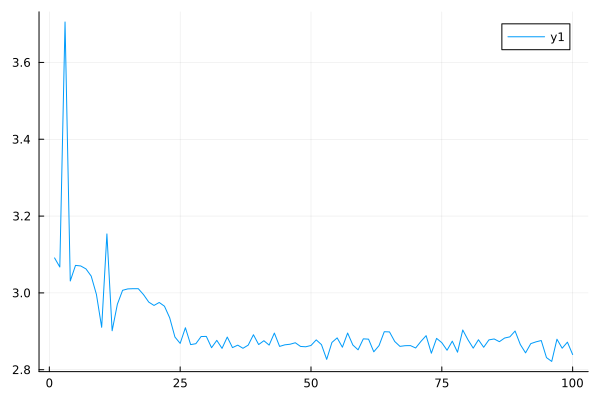

In [22]:
# A plot of the loss
using Plots
plot(toy_loss)

In [23]:
# This model is basically the same as the one above but with a few tricks, I'm only going to comment on these
using Flux
using Zygote: checkpointed
using Statistics

# For one I'm using a SwiGLU which is an activation function which one can use instead of ReLU which is the classical example
# It gives better gradient flows in deep networks. Read more here: https://paperswithcode.com/method/swiglu
struct SwiGLU
    W1::Dense
    W2::Dense
end

Flux.@layer SwiGLU

function SwiGLU(in_dim::Int, hidden_dim::Int)
    SwiGLU(
        Dense(in_dim, hidden_dim),
        Dense(in_dim, hidden_dim)
    )
end

function (sg::SwiGLU)(x)
    return sg.W1(x) .* Flux.sigmoid.(sg.W2(x))
end

struct ARTransformerLayer
    attention::Attention
    ff::Chain
    # Here we also use normalisation to help stabilise the training: https://arxiv.org/abs/1910.07467
    # https://arxiv.org/pdf/2002.04745
    norm1::RMSNorm
    norm2::RMSNorm
    # I then also have dropout which is a trick which is used to prevent overfitting: https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9/
    dropout::Dropout
end

Flux.@layer ARTransformerLayer

function ARTransformerLayer(dim::Int, n_head::Int, dropout_rate::Float32)
    return ARTransformerLayer(
        Attention(dim, n_head),
        Chain(
            SwiGLU(dim, dim * 4),
            Dense(dim * 4, dim)
        ),
        RMSNorm(dim),
        RMSNorm(dim),
        Dropout(dropout_rate)
    )
end

function (layer::ARTransformerLayer)(x::AbstractArray)
    seqlen = size(x, 2)
    h = zeros(Float32, layer.attention.dim, seqlen, 1)
    mask = causal_mask(h)
    rope = RoPE(layer.attention.head_dim, seqlen)

    attn_out = layer.attention(layer.norm1(x), 1, rope, mask)
    x = x + Flux.dropout(attn_out, layer.dropout.p)

    ff_out = layer.ff(layer.norm2(x))
    x = x + Flux.dropout(ff_out, layer.dropout.p)
    
    return x
end

struct ImprovedModel
    vocab_embed::Dense
    layers::Vector{ARTransformerLayer}
    final::Chain
end

Flux.@layer ImprovedModel

function ImprovedModel(vocab_size::Int, dim::Int, n_layers::Int, n_heads::Int, dropout_rate::Float32)
    vocab_embed = Dense(vocab_size, dim, bias=false)
    layers = [ARTransformerLayer(dim, n_heads, dropout_rate) for _ in 1:n_layers]
    final = Chain(
        RMSNorm(dim),
        Dense(dim, vocab_size)
    )
    return ImprovedModel(vocab_embed, layers, final)
end

function (model::ImprovedModel)(x::AbstractArray)
    x = model.vocab_embed(x)
    for layer in model.layers
        # Here I also use gradient checkpointing which is a trick to allow for bigger models: https://paperswithcode.com/method/gradient-checkpointing
        x = checkpointed(layer, x)
    end
    return model.final(x)
end

In [26]:
dropout_rate = 0.1f0
layers = 8
dim = 128
n_heads = 2
 
model = ImprovedModel(vocab_size, dim, layers, n_heads, dropout_rate)
base_lr = 0.001f0
rule = Optimisers.Adam(base_lr) 
opt_state = Optimisers.setup(rule, model)

(vocab_embed = (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = (), σ = ()), layers = @NamedTuple{attention::@NamedTuple{wq::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wk::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wv::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, bias::Tuple{}, σ::Tuple{}}, wo::@NamedTuple{weight::Optimisers.Leaf{Adam{Float32, Tuple{Float64, Float64}, Float64}, Tuple{Matrix{Float

In [27]:
model, improved_loss = train_ar_model(model, batches[1:100], opt_state)

3.9736392
3.827649
3.7222044
3.2871213
3.0097704
2.8940656
2.8884637
2.8412313
2.830106
2.819022
2.732417
2.7458684
2.7277324
2.7249253
2.6930015
2.6497896
2.6836078
2.561738
2.5338717
2.4963238
2.6208463
2.508932
2.514549
2.422645
2.4131181
2.359625
2.3814113
2.1463122
2.3268945
2.434292
2.1708136
2.3460538
2.1187754
2.2181952
2.1581728
1.9968964
2.0828059
2.0462942
2.0186296
1.7370061
1.6771889
1.750224
1.8745668
1.5385408
1.736633
1.5342318
1.2336196
1.4817284
1.7180281
1.477541
1.4616587
1.2782574
1.1241927
1.3843576
1.5579383
1.2714173
1.2576457
1.2295457
1.0905538
1.2799876
1.1036551
1.076991
1.3734944
1.6947546
1.3636255
1.330712
0.9183054
1.2543826
0.95442504
0.8355622
1.1141821
1.0622885
0.7416161
0.7739282
0.86074233
0.74753934
0.7468023
0.9010777
1.0444187
0.8272786
0.62195355
1.0280789
0.8651155
1.1474582
0.77188796
0.5130211
1.1460265
0.6985978
0.86331874
1.0196549
0.99700034
0.8354189
0.7107828
0.7986897
0.8646101
0.7326718
0.7868649
0.7832988
0.7207229
0.88288957


(ImprovedModel(Dense(22 => 128; bias=false), ARTransformerLayer[ARTransformerLayer(Attention{Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}}(Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), Dense(128 => 128; bias=false), 128, 2, 2, 64), Chain(SwiGLU(Dense(128 => 512), Dense(128 => 512)), Dense(512 => 128)), RMSNorm{Float32, Vector{Float32}}(Float32[1.0202079, 1.0088698, 1.0088199, 1.0198886, 1.0157123, 1.0200112, 1.0007889, 1.0001472, 1.0067984, 1.029152  …  1.0158132, 1.0290358, 1.0039921, 1.0005008, 1.0163653, 1.0002795, 1.007354, 1.0051079, 1.0068612, 1.011573], 1.0f-5), RMSNorm{Float32, Vector{Float32}}(Float32[1.0356601, 1.0193219, 1.0124823, 0.9961087, 1.0044967, 1.021329, 1.007686, 1.0234483, 1.0145389, 1.0226994  …  1.0038561, 1.0422041, 1.0196836, 1.0123327, 1.0100799, 1.0238266, 1.0175889, 1

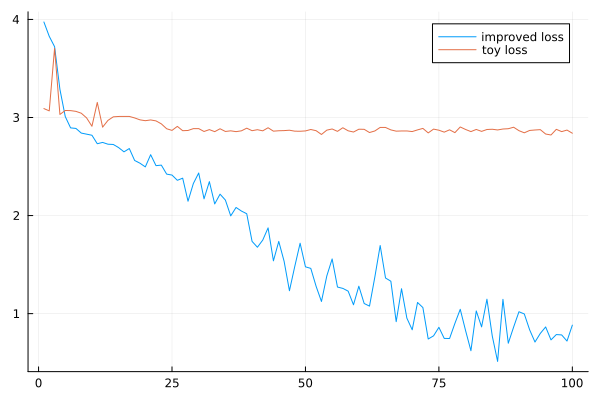

In [ ]:
# The loss of the improved model seems to decrease a lot quicker! A good sign
using Plots
plot(improved_loss, label="improved loss")
plot!(toy_loss, label="toy loss")

In [33]:
# Here I pass just a beginning-of-sequence token to our model and it predicts what it thinks that the first token should be
# We will however have to normalise these outputs using a softmax function to get the actual probabilities
x = Flux.onehotbatch("#",alphabet)
x = reshape(x,(22,1,1))
logits = model(x)

22×1×1 Array{Float32, 3}:
[:, :, 1] =
 -0.7675283
 -1.2492194
 -0.81128615
 -1.9402307
  4.681537
 -1.317524
 -0.5782627
 -0.52665794
 -1.3640952
 -1.3325182
  0.19883598
  0.42779666
 -0.109821245
 -1.4178876
  4.8161964
 -0.8528526
 -4.0018697
 -1.0516504
  1.3994135
 -0.17169364
 -1.2398024
  1.210072

In [34]:
# Here are the actual probabilities
for (letter,prob) in zip(alphabet,softmax(logits))
    if true || prob >= 0.1
        println(letter, " : ", prob)
    end
end

- : 0.18721215
A : 0.11564805
C : 0.17919686
D : 0.057947654
E : 43.534462
F : 0.1080125
G : 0.22622004
H : 0.23820053
I : 0.10309756
K : 0.106405035
L : 0.49206302
M : 0.61866736
N : 0.36138707
P : 0.097698204
Q : 49.80982
R : 0.17190088
S : 0.007373568
T : 0.14090987
V : 1.6346508
W : 0.33970484
Y : 0.11674226
# : 1.3526798


In [41]:
x = "#"

"#"

In [42]:
# Here we have a very simple greedy sampling loop, which simply starts from a #-token and then just iteratively adds new tokens for 130 steps
for i in 1:130
    x *= Flux.onecold(model(reshape(onehotbatch(x, alphabet), (vocab_size, length(x), 1))), alphabet)[end]
end
# Note that this is something you would want to optimise more in an actual model and you also in general won't just sample greedily but will instead sample
# from the distribution. It is however normal to weight this distribution using something known as temperature

In [43]:
x

"#QQQLQESGPGVVQPSLRSLSLTCAASGFTFSYGYWISQAPPGKGRWIGWIGNYYSRQGNTTSVKSRQGTISRDTSKNTLSVYLSSVTAAADTAVYCAQNYYYYYYYYYWGWGWGTVTVTVS---------"

In [ ]:
# Here I ran two models which had trained on 100 and 500 batches respectively. The number in paranthesis is the identity to the closest real *germline* sequence
# 100 batches: QQQLQESGPGVVQPSLRSLSLTCAASGFTFSYGYWISQAPPGKGRWIGWIGNYYSRQGNTTSVKSRQGTISRDTSKNTLSVYLSSVTAAADTAVYCAQNYYYYYYYYYWGWGWGTVTVTVS (54%)
# 500 batches: QVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLEWMGWINPNSGGTDYAQKFQGRVTMTRDTSISTAYMEVSSLSSDDTAVYYCARDTRGDYSYYYDAIWGTLVWGQGQGTVSS (83%)

In [ ]:
# Above we've created our own transformer layers which is sometimes necessary/nice to do, but you can also use this one from the Onion.jl package (or alternatives in Transformers.jl)
TransformerBlock

TransformerBlock

In [25]:
# By using that, we can really reduce our transformer to only this!:
struct OnionModel
    vocab_embed::Dense
    layers::Vector{TransformerBlock}
    final::Chain
end

Flux.@layer OnionModel

function OnionModel(vocab_size::Int, dim::Int, n_layers::Int, n_heads::Int)
    vocab_embed = Dense(vocab_size, dim, bias=false)
    layers = [TransformerBlock(dim, n_heads) for _ in 1:n_layers]
    final = Chain(
        RMSNorm(dim),
        Dense(dim, vocab_size)
    )
    return OnionModel(vocab_embed, layers, final)
end

function (model::OnionModel)(x::AbstractArray)
    x = model.vocab_embed(x)
    h = randn(Float32, dim, size(x,2), 1)
    rope = RoPE(dim ÷ n_heads, size(x,2))
    mask = Onion.causal_mask(h)
    for layer in model.layers
        x = checkpointed(layer, x, 1, rope, mask)
    end
    return model.final(x)
end

In [ ]:
dropout_rate = 0.1f0
layers = 8
dim = 128
n_heads = 2
 
model = OnionModel(vocab_size, dim, layers, n_heads)
base_lr = 0.001f0
rule = Optimisers.Adam(base_lr) 
opt_state = Optimisers.setup(rule, model)

model = train_ar_model(model, batches[1:500], opt_state)

In [ ]:
# Hope you enjoyed, good luck!